Epoch 0, Loss: 3.567295551300049
Epoch 1000, Loss: 0.0007853170391172171
Epoch 2000, Loss: 3.51838389178738e-05
Epoch 3000, Loss: 1.0412866686237976e-05
Epoch 4000, Loss: 3.6934466152160894e-06
Epoch 5000, Loss: 0.00014492029731627554
Epoch 6000, Loss: 1.8717880720942048e-06
Epoch 7000, Loss: 1.6732769836380612e-06
Epoch 8000, Loss: 1.2326880096225068e-05
Epoch 9000, Loss: 1.791171030163241e-06
Epoch 10000, Loss: 1.1892072961927624e-06


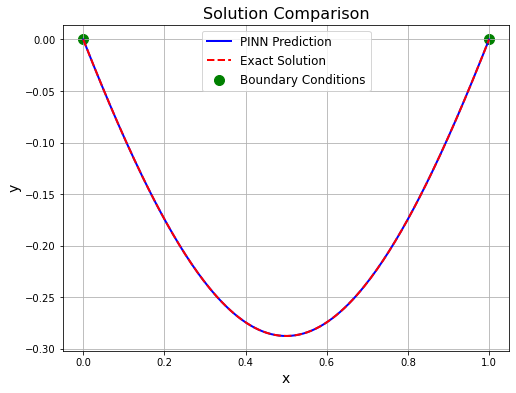

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define PINN neural network model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define 4 fully connected layers: input layer with 1 node, 3 hidden layers with 20 nodes each, output layer with 1 node
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.activation = torch.tanh  # Use tanh activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate training data
n_points = 200  # Number of internal points
# Internal points: uniformly sampled in [0,1] interval, with gradient requirement
X_in = torch.linspace(0, 1, n_points).view(-1, 1).requires_grad_(True)
# Boundary points: x=0 and x=1, also require gradients
X_bc = torch.tensor([[0.0], [1.0]], requires_grad=True)

# Training parameters
epochs = 10000  # Number of training epochs

# Training loop
for epoch in range(epochs + 1):
    optimizer.zero_grad()
    
    # Calculate internal point predictions and their derivatives
    y_in = model(X_in)
    # First derivative: dy/dx
    y_prime = torch.autograd.grad(
        y_in, X_in,
        grad_outputs=torch.ones_like(y_in),
        create_graph=True
    )[0]
    # Second derivative: d²y/dx²
    y_double_prime = torch.autograd.grad(
        y_prime, X_in,
        grad_outputs=torch.ones_like(y_prime),
        create_graph=True
    )[0]
    
    # Differential equation residual: y'' + (y')² - 2e^{-y}
    equation = y_double_prime + y_prime**2 - 2*torch.exp(-y_in)
    loss_equation = torch.mean(equation**2)  # Equation loss
    
    # Boundary condition loss
    y_bc = model(X_bc)
    loss_bc = torch.mean((y_bc - 0)**2)  # y=0 at boundaries
    
    # Total loss
    total_loss = loss_equation + loss_bc
    
    # Backward propagation
    total_loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item()}')

# Model evaluation
model.eval()
# Generate test points
x_test = torch.linspace(0, 1, 200).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy()

# Calculate exact solution
def exact_solution(x):
    return np.log((x - 0.5)**2 + 3/4)

x_np = x_test.numpy().flatten()
y_exact = exact_solution(x_np)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_np, y_pred, 'b-', linewidth=2, label='PINN Prediction')
plt.plot(x_np, y_exact, 'r--', linewidth=2, label='Exact Solution')
plt.scatter([0, 1], [0, 0], c='g', s=100, label='Boundary Conditions')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=12)
plt.title('Solution Comparison', fontsize=16)
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999999901003269, mae_pinn: 8.22022593638394e-06, rmse_pinn: 8.774815796641633e-06, inf_norm_pinn: 1.341104507446289e-05


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_14.csv', index=False)
print(" pinn_14.csv")

数据已保存至 pinn_14.csv
